In [283]:

def Surface_Greens_1D(En, g, b, Us, layers):

    Energy = En # Energy
    z = 10**-8 # Imaginary Portion Added to Energy

    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    Gamma = g # Gamme
    Beta = b # Beta
    potential = Us # Potentail
    E = Energy+z*1j-potential

    # Create Hamiltonian
    alpha = np.zeros((n,n,P),dtype=complex)
    tau = np.zeros((n,n,P),dtype=complex)
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))

    H = np.zeros((N*P*n,N*P*n),dtype=complex)
    for i in range(N):
        for k in range(P):
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
            
            if i*P+(k+1)<P*N:
                H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
                H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = np.conj(tau[:,:,k])
                
    # Condensation Algorithm ##################################################################
    C = H[n:P*n,n:P*n]
                
    C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

    # Makes Condensation Matices
    Xi_s = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))
    Xi = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))+mul(tau[:,:,P-1],mul(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n],tau[:,:,P-1].T.conj()))
    Pi = mul(tau[:,:,0],mul(C_tilde[0:n,(P-2)*n:(P-1)*n],tau[:,:,P-1]))

    # Condensed Matrix
    H_conds = np.zeros((N*n,N*n),dtype=complex)
    for i in range(N):
        if i == 0:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi_s
        else:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi
            H_conds[(i-1)*n:i*n,i*n:(i+1)*n] = Pi
            H_conds[i*n:(i+1)*n,(i-1)*n:i*n] = Pi.T.conj()
            
    # Eigenvalue Formulation ##################################################################
    # Eigenvalue Matrices
    A = np.zeros((2*n,2*n),dtype=complex)
    A[0:n,n:2*n] = np.diag(np.ones(n))
    A[n:2*n,0:n] = Pi.T.conj()
    A[n:2*n,n:2*n] = -(E*np.diag(np.ones(n))-Xi)
        
    B = np.zeros((2*n,2*n),dtype=complex)
    B[0:n,0:n] = np.diag(np.ones(n))
    B[n:2*n,n:2*n] = -Pi

    # Selcting eigenvalues with mag of less than one
    U = np.linalg.eig(mul(inv(B),A)).eigenvectors
    Lambda = np.linalg.eig(mul(inv(B),A)).eigenvalues

    indices = np.where(Lambda == min(Lambda))
    U = U[0:n,indices[0]]
    Lambda = np.diag(Lambda[indices[0]])

    # Pseudo invert U
    Q,R = np.linalg.qr(U)
    U_tilde = mul(inv(R),Q.T.conj())

    # Self Energy Matrix
    F = mul(U,mul(Lambda,U_tilde))
    Sigma_dash = mul(Pi,F)

    # Green's function
    g_00_eig = inv(E*np.diag(np.ones(n))-Xi_s-Sigma_dash)

    # Decimation Formulation ##################################################################
    # Initial matrices
    mu_0 = (E)*np.diag(np.ones(n))-Xi_s
    nu_0 = (E)*np.diag(np.ones(n))-Xi
    gamma_0 = Pi
    
    mu_old = mu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))
    nu_old = nu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))-mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0))
    gamma_old = mul(gamma_0,mul(inv(nu_0),gamma_0))
    zeta_old = mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0.T.conj()))

    # Iterative Procedure
    iterations = 40
    for i in range(iterations-1):
        mu_new = mu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))
        nu_new = nu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))-mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old))
        gamma_new = mul(gamma_old,mul(inv(nu_old),gamma_old))
        zeta_new = mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old.T.conj()))

        mu_old = mu_new
        nu_old = nu_new
        gamma_old = gamma_new
        zeta_old = zeta_new

    g_00_dec = inv(mu_new)
    
    # Recursive (Datta) Formulation ##################################################################
    g_old = (E-Gamma**2)**(-1)*1j
    
    for i in range(iterations):
        if i%2 == 0:
            g_new = (E-Gamma**2*g_old)**(-1)
        else:
            g_new = (E-Beta**2*g_old)**(-1)
        g_old = g_new

    g_00_rec = g_new

    # Direct Formulation ##################################################################
    g_surf_conds = np.linalg.pinv(E*np.diag(np.ones(N*n))-H_conds)
    g_surf_conds_dir = g_surf_conds[0:n,0:n]

    g_surf = np.linalg.pinv(E*np.diag(np.ones(N*P*n))-H)
    g_surf_dir = g_surf[0:n,0:n]

    g_quadratic = 1/(2*Gamma**2*E)*(E**2+Gamma**2-Beta*np.conj(Beta)-np.sqrt((E**2+Gamma**2-Beta*np.conj(Beta))**2-4*Gamma**2*E**2))
        

    return([g_00_eig[0,0],g_00_dec[0,0],g_00_rec,g_quadratic,g_surf_conds_dir[0,0],g_surf_dir[0,0]])

In [230]:
def Greens_1D(En, g, b, surface_g, layers):
    Energy = En # Energy
    z = 10**-8 # Imaginary Portion Added to Energy

    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    Gamma = g # Gamme
    Beta = b # Beta
    E = Energy+z*1j


    # Create Hamiltonian
    alpha = np.zeros((n,n,P),dtype=complex)
    tau = np.zeros((n,n,P),dtype=complex)
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))
   
    H = np.zeros((N*P*n,N*P*n),dtype=complex)
    for i in range(N):
        for k in range(P):
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
            
            if i*P+(k+1)<P*N:
                H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
                H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = np.conj(tau[:,:,k])
          
    sigma = np.zeros((N*P*n,N*P*n),dtype=complex)
    sigma[0,0] = g**2*surface_g
    sigma[N*P-1,N*P-1] = g**2*surface_g
        
    return(inv(E*np.diag(np.ones(N*P*n))-H-sigma))

In [202]:
def calc_gamma_matrix(surface_g, g, layers,source):
    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    sigma = np.zeros((N*P*n,N*P*n),dtype=complex)
    
    if source == 1:
        sigma[0,0] = g**2*surface_g
    else:
        sigma[N*P-1,N*P-1] = g**2*surface_g
    
    return((sigma-sigma.T.conj())*1j)
    

In [284]:
# Test over several E values

Emin = -10
Emax = 3
stepsize = 0.01
Layers_probe = 2
Layers_device = 2

gamma_value = 2.5
beta_value = 2

ressults = np.zeros((int((Emax-Emin)/stepsize)+1,6),dtype=complex)
greens_func = np.zeros((int((Emax-Emin)/stepsize)+1,6,2*Layers_device,2*Layers_device),dtype=complex)

for i, E in enumerate(np.arange(Emin, Emax, stepsize)):
    ressults[i,:] = Surface_Greens_1D(E, gamma_value, beta_value, 0, Layers_probe)
    for k in range(6):
        greens_func[i,k,:,:] = Greens_1D(E, gamma_value, beta_value, ressults[i,k], Layers_device)

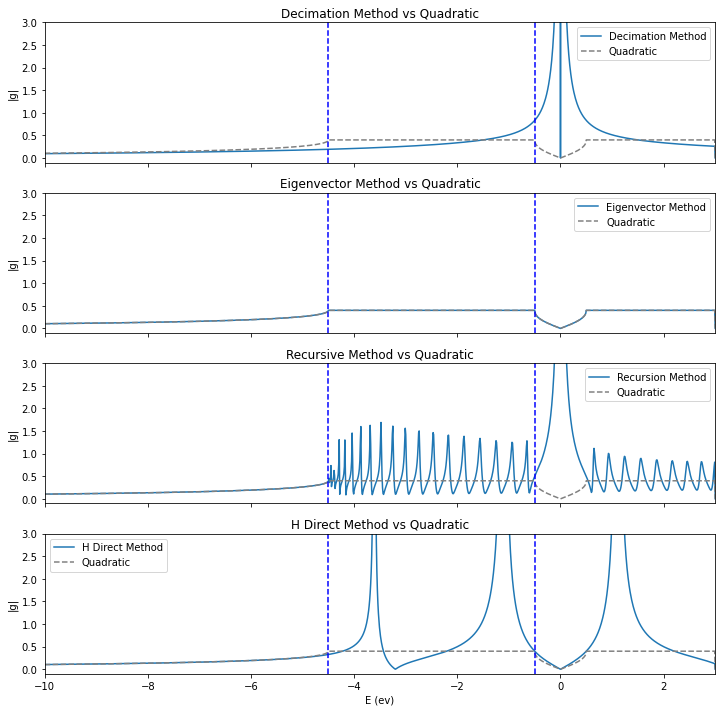

In [285]:
# Plotting 

x_values = np.linspace(Emin, Emax, int((Emax - Emin) / stepsize) + 1)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x_values, abs(abs(ressults[:, 1])), label="Decimation Method")
axs[1].plot(x_values, abs(abs(ressults[:, 0])), label="Eigenvector Method")
axs[2].plot(x_values, abs(abs(ressults[:, 2])), label="Recursion Method")
axs[3].plot(x_values, abs(abs(ressults[:, 4])), label="H Direct Method")

# Plotting the quadratic case in each subplot
for ax in axs:
    ax.plot(x_values, abs(abs(ressults[:, 3])), label="Quadratic", linestyle='--', color='gray')

# Adding vertical lines
for ax in axs:
    ax.axvline(x=-(beta_value + gamma_value), color='b', linestyle='--')
    ax.axvline(x=-(-beta_value + gamma_value), color='b', linestyle='--')

axs[3].set_xlabel('E (ev)')
for ax in axs:
    ax.set_ylabel('|g|')
    ax.set_xlim(Emin, Emax)
    ax.set_ylim(-0.1, 3)
    ax.legend()

axs[0].set_title('Decimation Method vs Quadratic')
axs[1].set_title('Eigenvector Method vs Quadratic')
axs[2].set_title('Recursive Method vs Quadratic')
axs[3].set_title('H Direct Method vs Quadratic')

plt.tight_layout()
plt.show()


In [575]:

# Define Conditions
import numpy as np
import sympy as sp
from numpy.linalg import inv
from numpy import matmul as mul

import time
import matplotlib.pyplot as plt

Energy = -0.5 # Energy
z = 10**-18 # Imaginary Portion Added to Energy
E = Energy+z*1j

oneD_test = False # Test for 1D chain
Gamma = 2.5 # Gamma
Beta = 2 # Beta
potential = 0 # Potentail

n = 4 # Atoms per layer
P = 6 # Periodicity
if oneD_test == True:
    n = 1
    P = 2
N = 400 # Number of periods

# Create Hamiltonian
alpha = np.zeros((n,n,P),dtype=complex)
tau = np.zeros((n,n,P),dtype=complex)
if oneD_test == False:
    for i in range(P):
        alpha[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
        tau[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
else:
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))

H = np.zeros((N*P*n,N*P*n),dtype=complex)
for i in range(N):
    for k in range(P):
        H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
        
        if i*P+(k+1)<P*N:
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
            H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = tau[:,:,k].T.conj()
            
# Condensation Algorithm ##################################################################
C = H[n:P*n,n:P*n]
            
C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

# Makes Condensation Matices
Xi_s = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))
Xi = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))+mul(tau[:,:,P-1],mul(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n],tau[:,:,P-1].T.conj()))
Pi = mul(tau[:,:,0],mul(C_tilde[0:n,(P-2)*n:(P-1)*n],tau[:,:,P-1]))

# Condensed Matrix
H_conds = np.zeros((N*n,N*n),dtype=complex)
for i in range(N):
    if i == 0:
        H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi_s
    else:
        H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi
        H_conds[(i-1)*n:i*n,i*n:(i+1)*n] = Pi
        H_conds[i*n:(i+1)*n,(i-1)*n:i*n] = Pi.T.conj()
        
# Eigenvalue Formulation ##################################################################
# Eigenvalue Matrices
A = np.zeros((2*n,2*n),dtype=complex)
A[0:n,n:2*n] = np.diag(np.ones(n))
A[n:2*n,0:n] = -Pi.T.conj()
A[n:2*n,n:2*n] = E*np.diag(np.ones(n))-Xi
    
B = np.zeros((2*n,2*n),dtype=complex)
B[0:n,0:n] = np.diag(np.ones(n))
B[n:2*n,n:2*n] = Pi

# Selcting eigenvalues with mag of less than one
U = np.linalg.eig(mul(inv(B),A)).eigenvectors
Lambda = np.linalg.eig(mul(inv(B),A)).eigenvalues

if oneD_test == True:
    indices = np.where(Lambda == min(Lambda))
    U = U[0:n,indices[0]]
    Lambda = np.diag(Lambda[indices[0]])
else:
    indices = np.where(np.abs(Lambda) < 1)
    U = U[0:n,indices[0]]
    Lambda = np.diag(Lambda[indices[0]])
    

# Pseudo invert U
Q,R = np.linalg.qr(U)
U_tilde = mul(inv(R),Q.T.conj())

# Self Energy Matrix
F = mul(U,mul(Lambda,U_tilde))
Sigma_dash = mul(Pi,F)

# Green's function
g_00_eig = inv(E*np.diag(np.ones(n))-Xi_s-Sigma_dash)
print("Eigenvalue Method")
matprint(g_00_eig)

# Decimation Formulation ##################################################################
# Initial matrices
mu_0 = E*np.diag(np.ones(n))-Xi_s
nu_0 = E*np.diag(np.ones(n))-Xi
gamma_0 = Pi

mu_old = mu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))
nu_old = nu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))-mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0))
gamma_old = mul(gamma_0,mul(inv(nu_0),gamma_0))
zeta_old = mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0.T.conj()))

# Iterative Procedure ##################################################################
iterations = 10
for i in range(iterations-1):
    mu_new = mu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))
    nu_new = nu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))-mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old))
    gamma_new = mul(gamma_old,mul(inv(nu_old),gamma_old))
    zeta_new = mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old.T.conj()))

    mu_old = mu_new
    nu_old = nu_new
    gamma_old = gamma_new
    zeta_old = zeta_new

g_00_dec = inv(mu_new)
print("Decimation Method")
matprint(g_00_dec)

# Recursive (Datta) Formulation ##################################################################
if oneD_test == True:
    g_old = (E-Gamma**2)**(-1)

    for i in range(iterations):
        if i%2 == 0:
            g_new = (E-Gamma**2*g_old)**(-1)
        else:
            g_new = (E-Beta**2*g_old)**(-1)
        g_old = g_new
        
    g_00_rec = g_new

    print("Recursive Relation Datta")
    print(g_00_rec)

# Direct Formulation ##################################################################
g_surf_conds = inv(E*np.diag(np.ones(N*n))-H_conds)
g_surf_conds_dir = g_surf_conds[0:n,0:n]
print("Direct Condensed Method")
matprint(g_surf_conds_dir)

g_surf = inv(E*np.diag(np.ones(N*P*n))-H)
g_surf_dir = g_surf[0:n,0:n]
print("Direct Method")
matprint(g_surf_dir)

if oneD_test == True:
    g_quadratic = 1/(2*Gamma**2*(E-potential))*((E-potential)**2+Gamma**2-Beta*np.conj(Beta)-np.sqrt(((E-potential)**2+Gamma**2-Beta*np.conj(Beta))**2-4*Gamma**2*(E-potential)**2))
    print("Quadratic Formulation")
    print(g_quadratic)




Eigenvalue Method
-0.563532-0.120064j  -0.12726+0.730245j      1.88956-1.16638j  -0.715824+0.229278j  
  0.54065+0.857226j  0.203721-0.576421j    -3.18347+0.524156j   0.825706-0.557227j  
  0.814223-1.43892j  -1.01839+0.748515j      2.51831+2.47842j   -1.02194-0.110206j  
 0.122647+0.713558j  0.0637424-0.64267j  -0.848707+0.0200999j   0.077805+0.180387j  
Decimation Method
-0.540233+0.0334009j  -0.0109369+0.329606j      1.33339-1.03016j   -0.568876+0.204641j  
  0.590616+0.683925j  -0.0980471-0.234032j    -2.56164+0.653933j    0.660139-0.587965j  
   0.586534-1.35677j   -0.403168+0.818891j      2.17615+1.68735j  -0.931065+0.0909272j  
    0.1341+0.661961j  -0.0116213-0.535275j  -0.667618+0.0398119j   0.0255944+0.175869j  
Direct Condensed Method
-0.563532-0.120064j  -0.12726+0.730245j      1.88956-1.16638j  -0.715824+0.229278j  
  0.54065+0.857226j  0.203721-0.576421j    -3.18347+0.524156j   0.825706-0.557227j  
  0.814223-1.43892j  -1.01839+0.748515j      2.51831+2.47842j   -1.02194-0

In [570]:
# Inversion of C matrix recursively
C = H[n:P*n,n:P*n]
C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

H_tilde = np.zeros((n,n,P,P),dtype=complex)
H_tilde[:,:,P-1,P-1] = inv(E*np.diag(np.ones(n))-alpha[:,:,P-1])

for i in range(P-2,0,-1):
    H_tilde[:,:,i,i] = inv(E*np.diag(np.ones(n))-alpha[:,:,i]-mul(tau[:,:,i],mul(H_tilde[:,:,i+1,i+1],tau[:,:,i].T.conj())))
    H_tilde[:,:,i,P-1] = mul(H_tilde[:,:,i,i],mul(tau[:,:,i],H_tilde[:,:,i+1,P-1]))

C_find_tilde = np.zeros((n,n,P),dtype=complex)
C_find_tilde[:,:,1] = H_tilde[:,:,1,1]

for i in range(2,P):
    C_find_tilde[:,:,i] = H_tilde[:,:,i,i]+mul(H_tilde[:,:,i,i],mul(mul(tau[:,:,i-1].T.conj(),mul(C_find_tilde[:,:,i-1],tau[:,:,i-1])),H_tilde[:,:,i,i]))  

print("Top left elements")
matprint(H_tilde[:,:,1,1])
matprint(C_tilde[0:n,0:n])
print("_________________________________")
print("Top right elements")
matprint(C_tilde[0:n,(P-2)*n:(P-1)*n])
matprint(H_tilde[:,:,1,P-1])
print("Bottom right elements")
print("_________________________________") 
matprint(C_find_tilde[:,:,P-1])
matprint(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n])


Top left elements
7.28362-0.993138j   -3.3201+2.45702j  
-3.1381+0.426084j  1.42495-0.755061j  
7.28362-0.993138j   -3.3201+2.45702j  
-3.1381+0.426084j  1.42495-0.755061j  
_________________________________
Top right elements
0.0656594+0.484224j   0.644172-0.767223j  
-0.188824-0.133798j  -0.0497847+0.40201j  
0.0656594+0.484224j   0.644172-0.767223j  
-0.188824-0.133798j  -0.0497847+0.40201j  
Bottom right elements
_________________________________
-0.499321+0.10078j   0.203293+0.035067j  
0.421017+0.104452j  -0.642998+0.279419j  
-0.499321+0.10078j   0.203293+0.035067j  
0.421017+0.104452j  -0.642998+0.279419j  


In [484]:
theta = np.zeros((n,n,P),dtype=complex)
theta[:,:,0] = np.diag(np.ones(n))
theta[:,:,1] = mul(inv(tau[:,:,1]),alpha[:,:,1])

for i in range(2,P-1):
    theta[:,:,i] = mul(inv(tau[:,:,i]),mul(alpha[:,:,i],theta[:,:,i-1]))-mul(inv(tau[:,:,i]),mul(tau[:,:,i-1].T.conj(),theta[:,:,i-2],))

        


phi = np.zeros((n,n,P+1),dtype=complex)
phi[:,:,P] = np.diag(np.ones(n))
phi[:,:,P-1] = mul(inv(tau[:,:,P-2].T.conj()),alpha[:,:,P-1])
    
for i in range(P-2,1,-1):
    phi[:,:,i] = mul(inv(tau[:,:,i-1].T.conj()),mul(alpha[:,:,i],phi[:,:,i+1]))-mul(inv(tau[:,:,i-1].T.conj()),mul(tau[:,:,i],phi[:,:,i+2]))
      

C_tilde_11 = inv(alpha[:,:,1]-mul(tau[:,:,1],mul(phi[:,:,3],inv(phi[:,:,2]))))
C_tilde_nn = inv(alpha[:,:,P-2]-mul(tau[:,:,P-1].T.conj(),mul(theta[:,:,P-3],inv(theta[:,:,P-2]))))

matprint(C_tilde_11)
        
C_tilde_real = inv(C)
    
matprint(C_tilde_real[0:n,0:n])
matprint(C_tilde_real)

-0.600457+0.980518j  0.881778-0.538716j       0.1757-0.4579j  
  -1.02515-1.03554j  0.123025-0.607992j    0.401933+1.85392j  
  1.07274-0.875274j  -0.340122+1.11918j  -0.797172-0.926548j  
  2.23263+1.50627j   0.780555-0.347583j   -1.48673-2.01273j  
 1.89035-0.536966j  -1.99092-0.0131474j  0.340583-0.789695j  
-2.60505-0.536103j   0.725278+0.565678j    1.00657+1.09233j  
  2.23263+1.50627j    0.780555-0.347583j    -1.48673-2.01273j    0.67373+0.416394j   1.71347+0.894667j   -2.12835-0.760174j     0.54043-1.44787j    0.319211-0.512355j   -0.694375+1.13007j  
 1.89035-0.536966j   -1.99092-0.0131474j   0.340583-0.789695j   -1.12153+0.827776j   1.77485+0.395999j  -0.911088-0.837828j      1.7287-2.10576j   -0.703076-0.336444j     -1.6607+1.65418j  
-2.60505-0.536103j    0.725278+0.565678j     1.00657+1.09233j   0.456046-0.291673j  -2.44222-0.268452j    2.20622+0.421703j    -1.07426+2.14476j    0.326867+0.572317j      1.14216-1.9482j  
  1.34094-2.18205j     0.425252-1.08133j    -1.41318+1.

In [15]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")